**Image classification model using dataset Kaggel**

**Install Required Libraries and Authenticate Kaggle
python**

In [5]:
!pip install -q kaggle

from google.colab import files
files.upload()  # upload your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Download the dataset from Kaggle**

In [6]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

# Unzip the downloaded dataset
!unzip -q satellite-image-classification.zip -d satellite_data

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
  0% 0.00/21.8M [00:00<?, ?B/s]
100% 21.8M/21.8M [00:00<00:00, 544MB/s]


**Data Augmentation & Generators
python**

In [7]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# Define source and target directories
original_data_dir = "satellite_data/data"
base_dir = "satellite_data/split_data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Create split folders if not exist
if not os.path.exists(base_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    class_names = os.listdir(original_data_dir)

    for class_name in class_names:
        class_path = os.path.join(original_data_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        split_idx = int(0.8 * len(images))
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(test_dir, class_name))

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Define data generators
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.


**Import Librariest**

In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Load Base Model**

In [9]:
# Step 1: Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for transfer learning

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Build Full Model**

In [10]:
# Step 2: Build the full classification model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

**Compile Model**

In [11]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

In [12]:
epochs = 3

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('xception_best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7091 - loss: 0.9249

141/141 ━━━━━━━━━━━━━━━━━━━━ 1211s 9s/step - accuracy: 0.7101 - loss: 0.9229 - val_accuracy: 0.9618 - val_loss: 0.3011
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9606 - loss: 0.2413

141/141 ━━━━━━━━━━━━━━━━━━━━ 1183s 8s/step - accuracy: 0.9606 - loss: 0.2411 - val_accuracy: 0.9716 - val_loss: 0.1566
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9578 - loss: 0.1629

141/141 ━━━━━━━━━━━━━━━━━━━━ 1149s 8s/step - accuracy: 0.9578 - loss: 0.1628 - val_accuracy: 0.9769 - val_loss: 0.1095


**Plot Accuracy & Loss Curves**

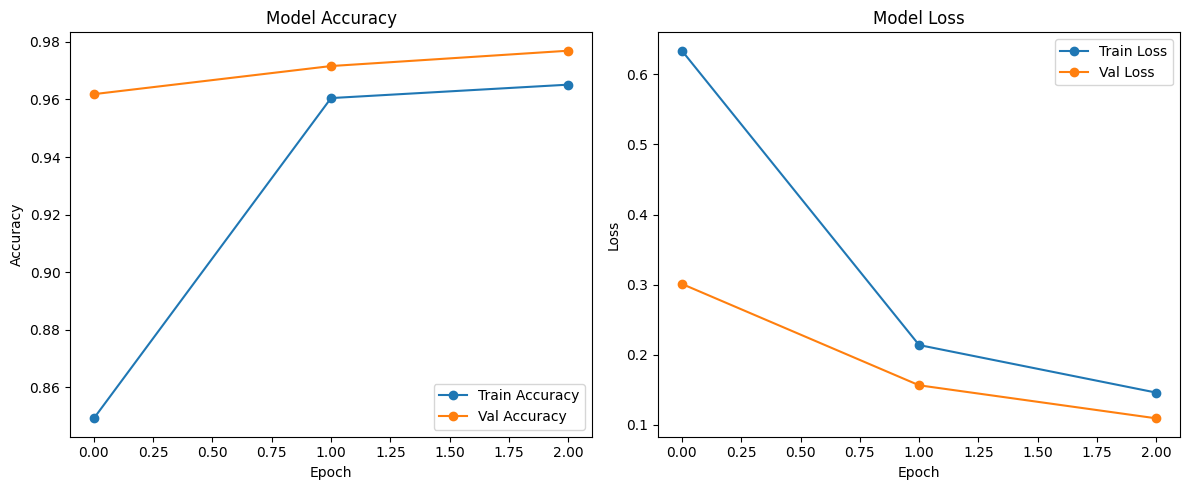

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


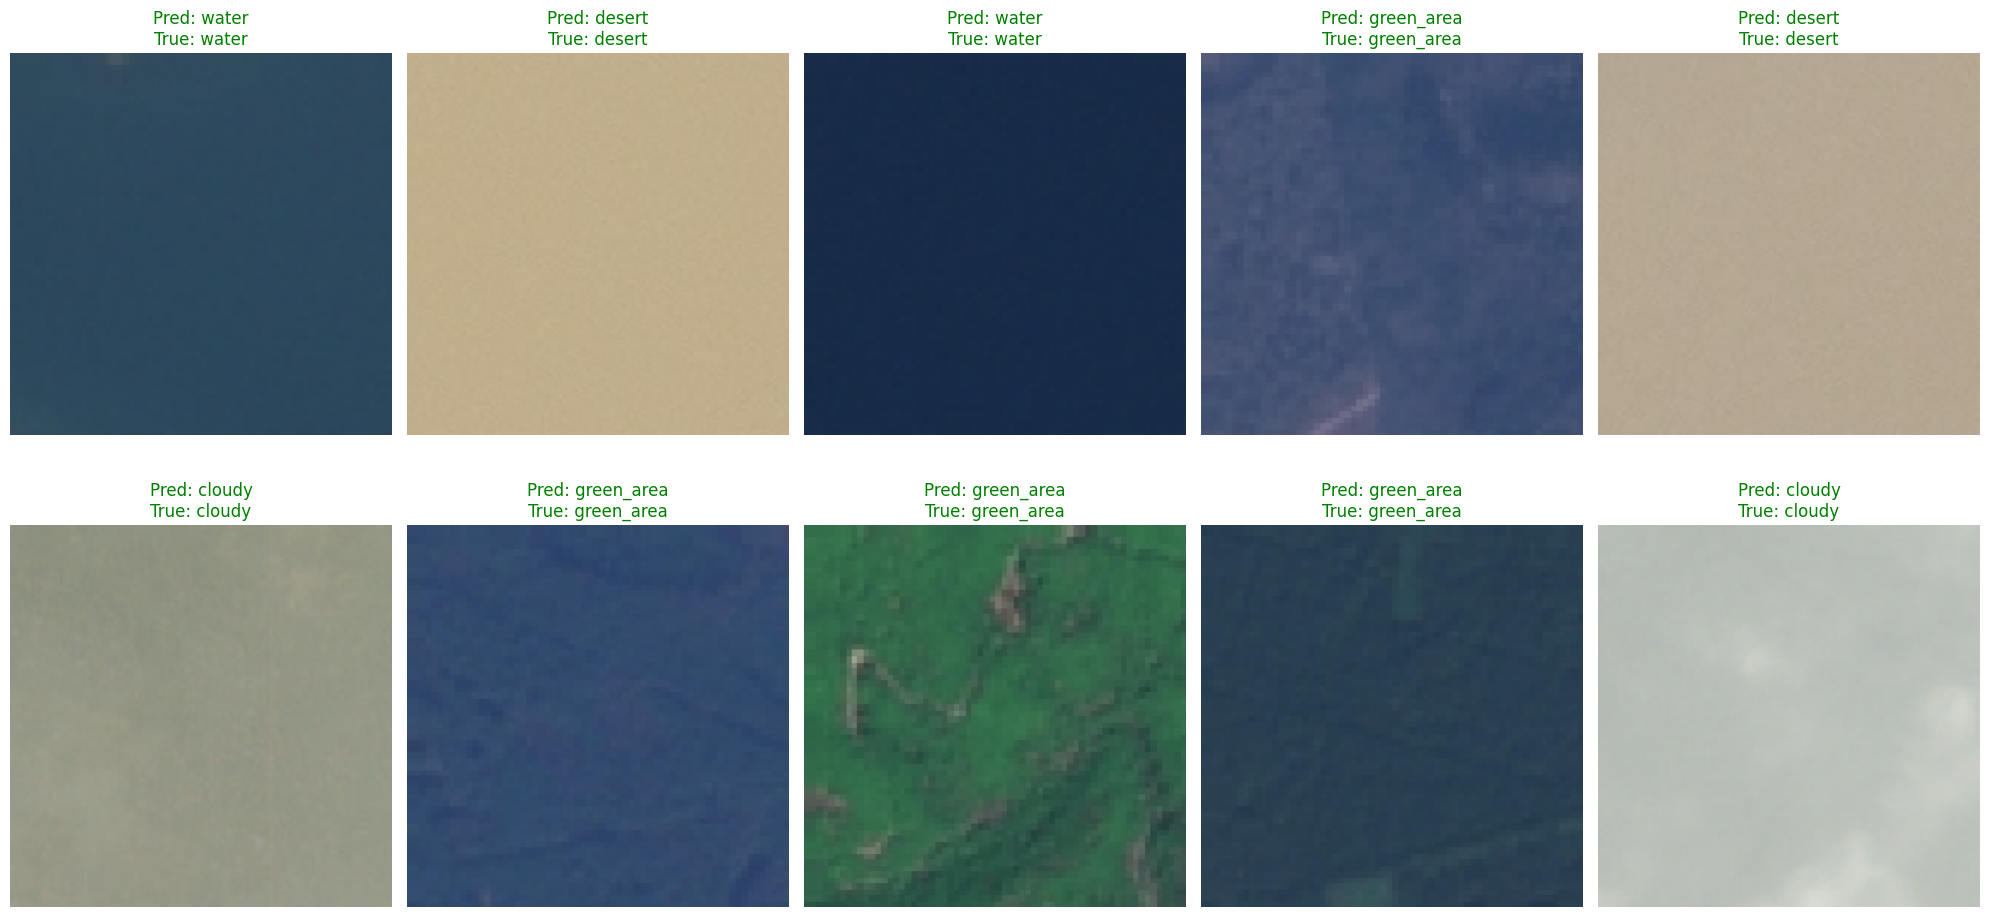

In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input  # if you're using Xception

# Ensure this matches the input shape your model expects
img_size = 224

val_path = test_dir  # Make sure test_dir is defined
class_labels = sorted(os.listdir(val_path))

plt.figure(figsize=(20, 10))

i = 0
while i < 10:
    # Randomly select a class and image
    class_name = random.choice(class_labels)
    class_dir = os.path.join(val_path, class_name)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    # Load and preprocess image
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # If your model requires it (e.g., Xception)
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Make prediction
    pred = model.predict(img_array_exp, verbose=0)
    pred_class = class_labels[np.argmax(pred)]

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)  # Directly use the PIL image
    plt.axis('off')
    color = 'green' if pred_class == class_name else 'red'
    plt.title(f"Pred: {pred_class}\nTrue: {class_name}", color=color)

    i += 1

plt.tight_layout()
plt.show()
